## Importing all the necessary dependencies

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam

## Loading the dataset

In [2]:
language_dataset = pd.read_csv('dataset.csv')

In [3]:
language_dataset.sample(5)

,Text,language
21202,그렇지만 미국은 오브레곤이 미국 오일 회사들을 몰수하지 않겠다고 약속한 년의 부카렐...,Korean
3471,ความเป็นอยู่ของมนุษย์ในทวีปทั้ง ยกเว้นชมพูทวี...,Thai
15940,боевые столкновения теракты и полицейские опер...,Russian
3614,कई स्थानों और उच्च पदों पर काम करते हुए पं डोग...,Hindi
20490,сами кагальные постановления использованные бр...,Russian


In [4]:
language_dataset.isnull().sum()

Text        0
language    0
dtype: int64

In [5]:
language_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


In [6]:
language_dataset['language'].value_counts()

language
Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: count, dtype: int64

## Checking for duplicate values in the dataset

In [7]:
language_dataset.duplicated().sum()

141

## Dropping the duplicate values from the dataset

In [8]:
language_dataset.drop_duplicates(inplace=True)

## Confirming whether the duplicate values are deleted from the dataset or not

In [9]:
language_dataset.duplicated().sum()

0

## Encoding the labels

In [10]:
encoder = LabelEncoder()

language_dataset['language_encoded'] = encoder.fit_transform(language_dataset['language'])

In [11]:
language_dataset.sample(5)

,Text,language,language_encoded
10136,ve larda takma adıyla vikinin özellikle kuant...,Turkish,20
141,ஸ்ரீநிவாச கல்யாணம் ஆம் ஆண்டு வெளிவந்த தமிழ்ப்...,Tamil,18
12315,ثم يحسب فرق زمن دوران الأرض حول نفسها بين المد...,Arabic,0
17743,i trakten råder ett hett ökenklimat årsmedelte...,Swedish,17
7646,de kilometer voor mannen werd na de diskwalif...,Dutch,2


## Identifying which integer is assigned to which label

In [12]:
language_label_identify_unique = language_dataset[['language', 'language_encoded']].drop_duplicates().sort_values(by='language_encoded')

In [13]:
language_label_identify_unique

,language,language_encoded
46,Arabic,0
13,Chinese,1
4,Dutch,2
37,English,3
0,Estonian,4
12,French,5
19,Hindi,6
10,Indonesian,7
5,Japanese,8
14,Korean,9


## Separating features and labels

In [14]:
X = language_dataset['Text']
y = language_dataset['language_encoded']

## Performing train test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing the data

In [16]:
y_train = to_categorical(y_train, num_classes=22)
y_test = to_categorical(y_test, num_classes=22)

In [17]:
word_tokenizer = Tokenizer()

In [18]:
word_tokenizer.fit_on_texts(X_train)

In [19]:
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [20]:
vocab_length = len(word_tokenizer.word_index) + 1

In [21]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
embedding_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding='utf8')


for line in glove_file:
    records = line.split()
    word = records[0]
    corresponding_vector_of_the_word = np.asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = corresponding_vector_of_the_word

glove_file.close()

In [23]:
embedding_matrix = np.zeros((vocab_length, 100))


for word, index in word_tokenizer.word_index.items():
    
    getting_corresponding_word_from_embedding_vector = embedding_dictionary.get(word)
    
    if getting_corresponding_word_from_embedding_vector is not None:
        
        embedding_matrix[index] = getting_corresponding_word_from_embedding_vector

In [24]:
embedding_matrix.shape

(234753, 100)

## Creating the embedding layer

In [25]:
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

## Defining the early stop

In [26]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

## Creating and training the model

In [27]:
model = Sequential()

In [28]:
model.add(embedding_layer)

model.add(Bidirectional(GRU(128, activation='tanh')))

model.add(Dense(128, activation='tanh'))

model.add(Dense(64, activation='tanh'))

model.add(Dense(32, activation='tanh'))

model.add(Dense(22, activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          23475300  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              176640    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 22)                726       
                                                        

In [30]:
model.compile(optimizer=Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(x=X_train, y=y_train, validation_data=[X_test, y_test], batch_size=64, epochs=100, callbacks=[early_stop_loss, early_stop_val_loss])

Epoch 1/100
274/274 [==============================] - 24s 45ms/step - loss: 3.0021 - accuracy: 0.1312 - val_loss: 2.8913 - val_accuracy: 0.1894
Epoch 2/100
274/274 [==============================] - 12s 43ms/step - loss: 2.8034 - accuracy: 0.2288 - val_loss: 2.7086 - val_accuracy: 0.2450
Epoch 3/100
274/274 [==============================] - 12s 43ms/step - loss: 2.6152 - accuracy: 0.2478 - val_loss: 2.5348 - val_accuracy: 0.2459
Epoch 4/100
274/274 [==============================] - 12s 43ms/step - loss: 2.4602 - accuracy: 0.2606 - val_loss: 2.4032 - val_accuracy: 0.2816
Epoch 5/100
274/274 [==============================] - 12s 44ms/step - loss: 2.3453 - accuracy: 0.3018 - val_loss: 2.2845 - val_accuracy: 0.3179
Epoch 6/100
274/274 [==============================] - 12s 43ms/step - loss: 2.2269 - accuracy: 0.3428 - val_loss: 2.1553 - val_accuracy: 0.3575
Epoch 7/100
274/274 [==============================] - 12s 44ms/step - loss: 2.0880 - accuracy: 0.3825 - val_loss: 2.0023 - val_ac

274/274 [==============================] - 14s 52ms/step - loss: 0.7467 - accuracy: 0.7228 - val_loss: 0.7715 - val_accuracy: 0.7253
Epoch 58/100
274/274 [==============================] - 14s 52ms/step - loss: 0.7441 - accuracy: 0.7233 - val_loss: 0.7704 - val_accuracy: 0.7276
Epoch 59/100
274/274 [==============================] - 15s 53ms/step - loss: 0.7415 - accuracy: 0.7252 - val_loss: 0.7692 - val_accuracy: 0.7242
Epoch 60/100
274/274 [==============================] - 15s 54ms/step - loss: 0.7388 - accuracy: 0.7267 - val_loss: 0.7666 - val_accuracy: 0.7219
Epoch 61/100
274/274 [==============================] - 15s 54ms/step - loss: 0.7363 - accuracy: 0.7237 - val_loss: 0.7667 - val_accuracy: 0.7283
Epoch 62/100
274/274 [==============================] - 14s 52ms/step - loss: 0.7346 - accuracy: 0.7255 - val_loss: 0.7653 - val_accuracy: 0.7251
Epoch 63/100
274/274 [==============================] - 14s 51ms/step - loss: 0.7321 - accuracy: 0.7279 - val_loss: 0.7632 - val_accuracy

## Plotting loss VS val_loss and accuracy VS val_accuracy graph

In [32]:
history = pd.DataFrame(model.history.history)

<Axes: >

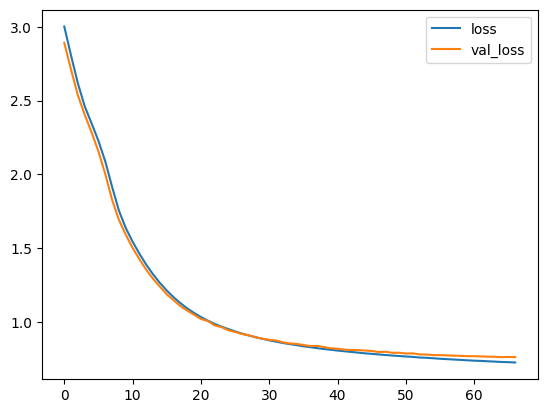

In [33]:
history[['loss', 'val_loss']].plot()

<Axes: >

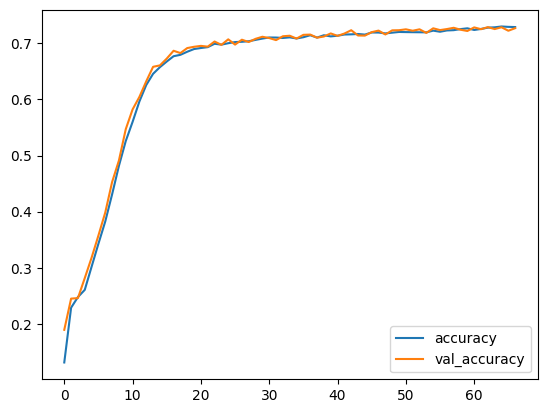

In [34]:
history[['accuracy', 'val_accuracy']].plot()

## Evaluating the model on training and testing data

In [35]:
model.evaluate(X_train, y_train)[1]

547/547 [==============================] - 9s 17ms/step - loss: 0.7268 - accuracy: 0.7289


0.7289415001869202

In [36]:
model.evaluate(X_test, y_test)[1]

137/137 [==============================] - 2s 17ms/step - loss: 0.7606 - accuracy: 0.7269


0.7268984317779541

## Performing prediction on sample data

In [37]:
sample_data = "klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemÃ¤rke  aastal viidi ta surnukeha mausoleumist Ã¤ra ja kremeeriti zlÃ­ni linn kandis aastatel â€“ nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel â€“ nime gotvald"

In [38]:
sample_data_sequence = word_tokenizer.texts_to_sequences([sample_data])

In [39]:
sample_data_padded = pad_sequences(sample_data_sequence, padding='post', maxlen=100)

In [40]:
prediction = model.predict(sample_data_padded)

1/1 [==============================] - 1s 920ms/step


In [41]:
predicted_class = np.argmax(prediction)

In [42]:
class_names = ['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French', 'Hindi', 'Indonesian', 'Japanese', 'Korean', 'Latin', 'Persian', 'Portugese', 'Pushto', 'Romanian', 'Russian', 'Spanish', 'Swedish', 'Tamil', 'Thai', 'Turkish', 'Urdu']

In [43]:
pred_final_result = class_names[predicted_class]

In [44]:
pred_final_result

'Estonian'

## Save the model

In [45]:
model.save('bidirectionalgru_model.h5')